In [2]:
import numpy as np
import scipy.fft as sp_fft

class JointChannelOF:

    def __init__(self, templates, noise_psds, sampling_frequency):
        """
        templates: list of 1D numpy arrays, one per channel
        noise_psds: list of 1D numpy arrays, one per channel
        """
        self._sampling_frequency = sampling_frequency
        self._n_channels = len(templates)
        self._length = len(templates[0])

        self.set_templates(templates)
        self.set_noise_psds(noise_psds)

    def set_templates(self, templates):
        self._templates = templates
        self._template_ffts = [sp_fft.rfft(tpl) / self._sampling_frequency for tpl in templates]
        self._update_kernels()

    def set_noise_psds(self, noise_psds):
        self._noise_psds = noise_psds

        self._inv_psds = []
        for psd in noise_psds:
            inv_psd = np.zeros_like(psd)
            inv_psd[1:] = 1.0 / (psd[1:] + 1e-30)
            if self._length % 2 == 0:
                inv_psd[-1] = 1.0 / (psd[-1] + 1e-30)
            inv_psd[0] = 0.0
            self._inv_psds.append(inv_psd)

        self._update_kernels()

    def _update_kernels(self):
        if hasattr(self, '_template_ffts') and hasattr(self, '_inv_psds'):
            self._kernels = []
            norms = []
            for tpl_fft, inv_psd in zip(self._template_ffts, self._inv_psds):
                kernel = tpl_fft.conjugate() * inv_psd
                norm = np.real(np.sum(kernel * tpl_fft)) * self._sampling_frequency / self._length
                self._kernels.append(kernel)
                norms.append(norm)

            self._kernel_normalization = np.sum(norms)

    def fit_with_shift(self, traces, allowed_shift_range=[-2000, 2000]):
        """
        traces: list of 1D numpy arrays, one per channel
        """
        filtered_traces_fft = []
        trace_ffts = []
        chisq0_total = 0.0

        for trace, kernel, norm, inv_psd in zip(
            traces, self._kernels,
            [np.real(np.sum(k * t)) * self._sampling_frequency / self._length for k, t in zip(self._kernels, self._template_ffts)],
            self._inv_psds
        ):
            tr_fft = sp_fft.rfft(trace) / self._sampling_frequency
            trace_ffts.append(tr_fft)
            filtered = kernel * tr_fft / norm
            filtered_traces_fft.append(filtered)

            chisq0 = np.real(np.vdot(tr_fft, tr_fft * inv_psd)) * self._sampling_frequency / self._length
            chisq0_total += chisq0

        # Sum of inverse FFTs of all channels => joint A(t0)
        amp_series = 0.5 * sum(sp_fft.irfft(filt) * self._sampling_frequency for filt in filtered_traces_fft)

        chisq_series = chisq0_total - amp_series**2 * self._kernel_normalization

        if allowed_shift_range is None:
            ind = np.arange(len(chisq_series))
        else:
            start = (self._length + allowed_shift_range[0]) % self._length
            stop = (allowed_shift_range[1] + 1) % self._length
            if start < stop:
                ind = np.arange(start, stop)
            else:
                ind = np.concatenate((np.arange(start, self._length), np.arange(0, stop)))

        best_ind = ind[np.argmin(chisq_series[ind])]
        amp = amp_series[best_ind]
        chisq = chisq_series[best_ind] / (self._length - 3)
        t0 = best_ind if best_ind < self._length // 2 else best_ind - self._length

        return amp, chisq, t0


In [1]:
import yaml
import numpy as np
import zstandard as zstd
import os
from TraceSimulator import TraceSimulator
from trace_IO import *
from OF_trigger import *

import matplotlib.pyplot as plt

def plot_trace_set(trace_set, offset=50):
    """
    Plot a single trace set (shape: 54 x N) with vertical offsets.

    Parameters:
    - trace_set: ndarray, shape (54, N)
    - offset: float, vertical offset between channels
    """
    n_channels, n_samples = trace_set.shape

    for i in range(n_channels):
        color = 'r' if i > 44 else 'b'
        plt.plot(np.arange(n_samples), trace_set[i] + i * offset, color=color, lw=0.2)

    plt.xlabel("Sample Index")
    plt.yticks([])
    plt.ylim(-10, offset * n_channels)
    plt.title("Trace Set")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict

config = read_yaml_to_dict('../archive/config.yaml')
ts = TraceSimulator(config)

In [ ]:
trace = ts.generate(E=1000, x=-40, y=80, z=-1800, no_noise=False, type_recoil='NR', quantize=True, phonon_only=True)
plot_trace_set(trace[0])

In [64]:
fs = 3906250
template = np.load("../templates/template_K_alpha_no_baseline.npy")
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")

# 1. Extract 9 vacuum channels
trace_vacuum = trace[0][45:]  # shape: (9, 32768)

# 2. Prepare replicated template and PSD
templates = [template] * 9     # template: 1D array, e.g., (32768,)
psds = [noise_psd] * 9         # noise_psd: 1D array, e.g., (16385,)

# 3. Initialize JointChannelOF
of = JointChannelOF(templates=templates, noise_psds=psds, sampling_frequency=fs)

# 4. Fit trace
amp, chisq, t0 = of.fit_with_shift(trace_vacuum)
print(f"UV template Amplitude: {amp:.4f}, Chi²: {chisq:.4f}, t₀: {t0} samples")


UV template Amplitude: 92.3330, Chi²: 1.2601, t₀: 1999 samples


In [65]:
fs = 3906250
template = np.load("../templates/template_qp_toy.npy")
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")

# 1. Extract 9 vacuum channels
trace_vacuum = trace[0][45:]  # shape: (9, 32768)

# 2. Prepare replicated template and PSD
templates = [template] * 9     # template: 1D array, e.g., (32768,)
psds = [noise_psd] * 9         # noise_psd: 1D array, e.g., (16385,)

# 3. Initialize JointChannelOF
of = JointChannelOF(templates=templates, noise_psds=psds, sampling_frequency=fs)

# 4. Fit trace
amp, chisq, t0 = of.fit_with_shift(trace_vacuum)
print(f"QP Amplitude: {amp:.4f}, Chi²: {chisq:.4f}, t₀: {t0} samples")


QP Amplitude: -73.8852, Chi²: 1.6495, t₀: -2000 samples


In [71]:

sampling_frequency = 3906250
template = np.load("../templates/template_qp_toy.npy")
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")

# Initialize Optimum Filter
trigger = OFtrigger(template, noise_psd, sampling_frequency)

In [72]:
# Initialize lists to hold fit results
amplitudes = []
chi2s = []
t0s = []

# Loop over all 54 channels
for i in range(45, 54):
    ampl, chi2, t0 = trigger.fit_with_shift(trace[0][i])
    amplitudes.append(ampl)
    chi2s.append(chi2)
    t0s.append(t0)
    print(f"Trace {i}: Amplitude = {ampl:.4f}, Chi2 = {chi2:.4f}, t0 = {t0:.4f}")

# Optionally convert to NumPy arrays
import numpy as np
amplitudes = np.array(amplitudes)
chi2s = np.array(chi2s)
t0s = np.array(t0s)


Trace 45: Amplitude = 15.1586, Chi2 = 0.2396, t0 = 1687.0000
Trace 46: Amplitude = -29.9525, Chi2 = 0.2741, t0 = -2000.0000
Trace 47: Amplitude = -18.2251, Chi2 = 0.2535, t0 = -2000.0000
Trace 48: Amplitude = 4.2518, Chi2 = 0.2299, t0 = 1945.0000
Trace 49: Amplitude = -2.9934, Chi2 = 0.2222, t0 = -1942.0000
Trace 50: Amplitude = -1.0230, Chi2 = 0.2202, t0 = -2000.0000
Trace 51: Amplitude = -3.0948, Chi2 = 0.2213, t0 = -1957.0000
Trace 52: Amplitude = -2.9016, Chi2 = 0.2239, t0 = -1370.0000
Trace 53: Amplitude = -6.7726, Chi2 = 0.2392, t0 = -1921.0000


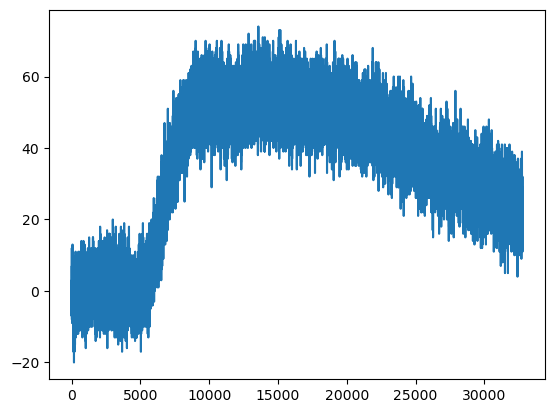

In [73]:
plt.plot(trace[0][46])